# Laboratorio 2 - Día 4
### Security Data Science
#### José Daniel Gómez Cabrera 21429

## Day 4 - Google Search grounding

In [27]:
%pip install -q -U 'google-generativeai>=0.8.3'

Note: you may need to restart the kernel to use updated packages.


In [28]:
import google.generativeai as genai
from IPython.display import Markdown, HTML, display

In [29]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")

genai.configure(api_key=GOOGLE_API_KEY)

In [30]:
for model in genai.list_models():
    if "002" in model.name:
        print(model.name)

models/gemini-1.5-pro-002
models/gemini-1.5-flash-002
models/imagen-3.0-generate-002


In [31]:
# Ask for information without search grounding.
model = genai.GenerativeModel("gemini-1.5-flash-002")

response = model.generate_content("When and where is Taylor Swift's next concert?")

Markdown(response.text)

I do not have access to real-time information, including constantly updating concert schedules.  To find the date and location of Taylor Swift's next concert, I recommend checking these resources:

* **Taylor Swift's Official Website:** This is the most reliable source.
* **Ticketmaster:**  Check for on-sale dates and locations.
* **Live Nation:** Another major ticket vendor.
* **Social Media:** Follow Taylor Swift's official social media accounts for announcements.


Keep in mind that concert dates sell out quickly, so be prepared to act fast if you find a show you want to attend.


In [39]:
# And now re-run the same query with search grounding enabled.
model = genai.GenerativeModel(
    "gemini-1.5-flash-002",
    tools="google_search_retrieval")

response = model.generate_content("When and where is Taylor Swift's next concert?")
rc = response.candidates[0]

Markdown(rc.content.parts[0].text)

ResourceExhausted: 429 Resource has been exhausted (e.g. check quota).

### Obtuve el error, entonces utilice el servicio de Google AI Studio, tal y como la guia lo indica.

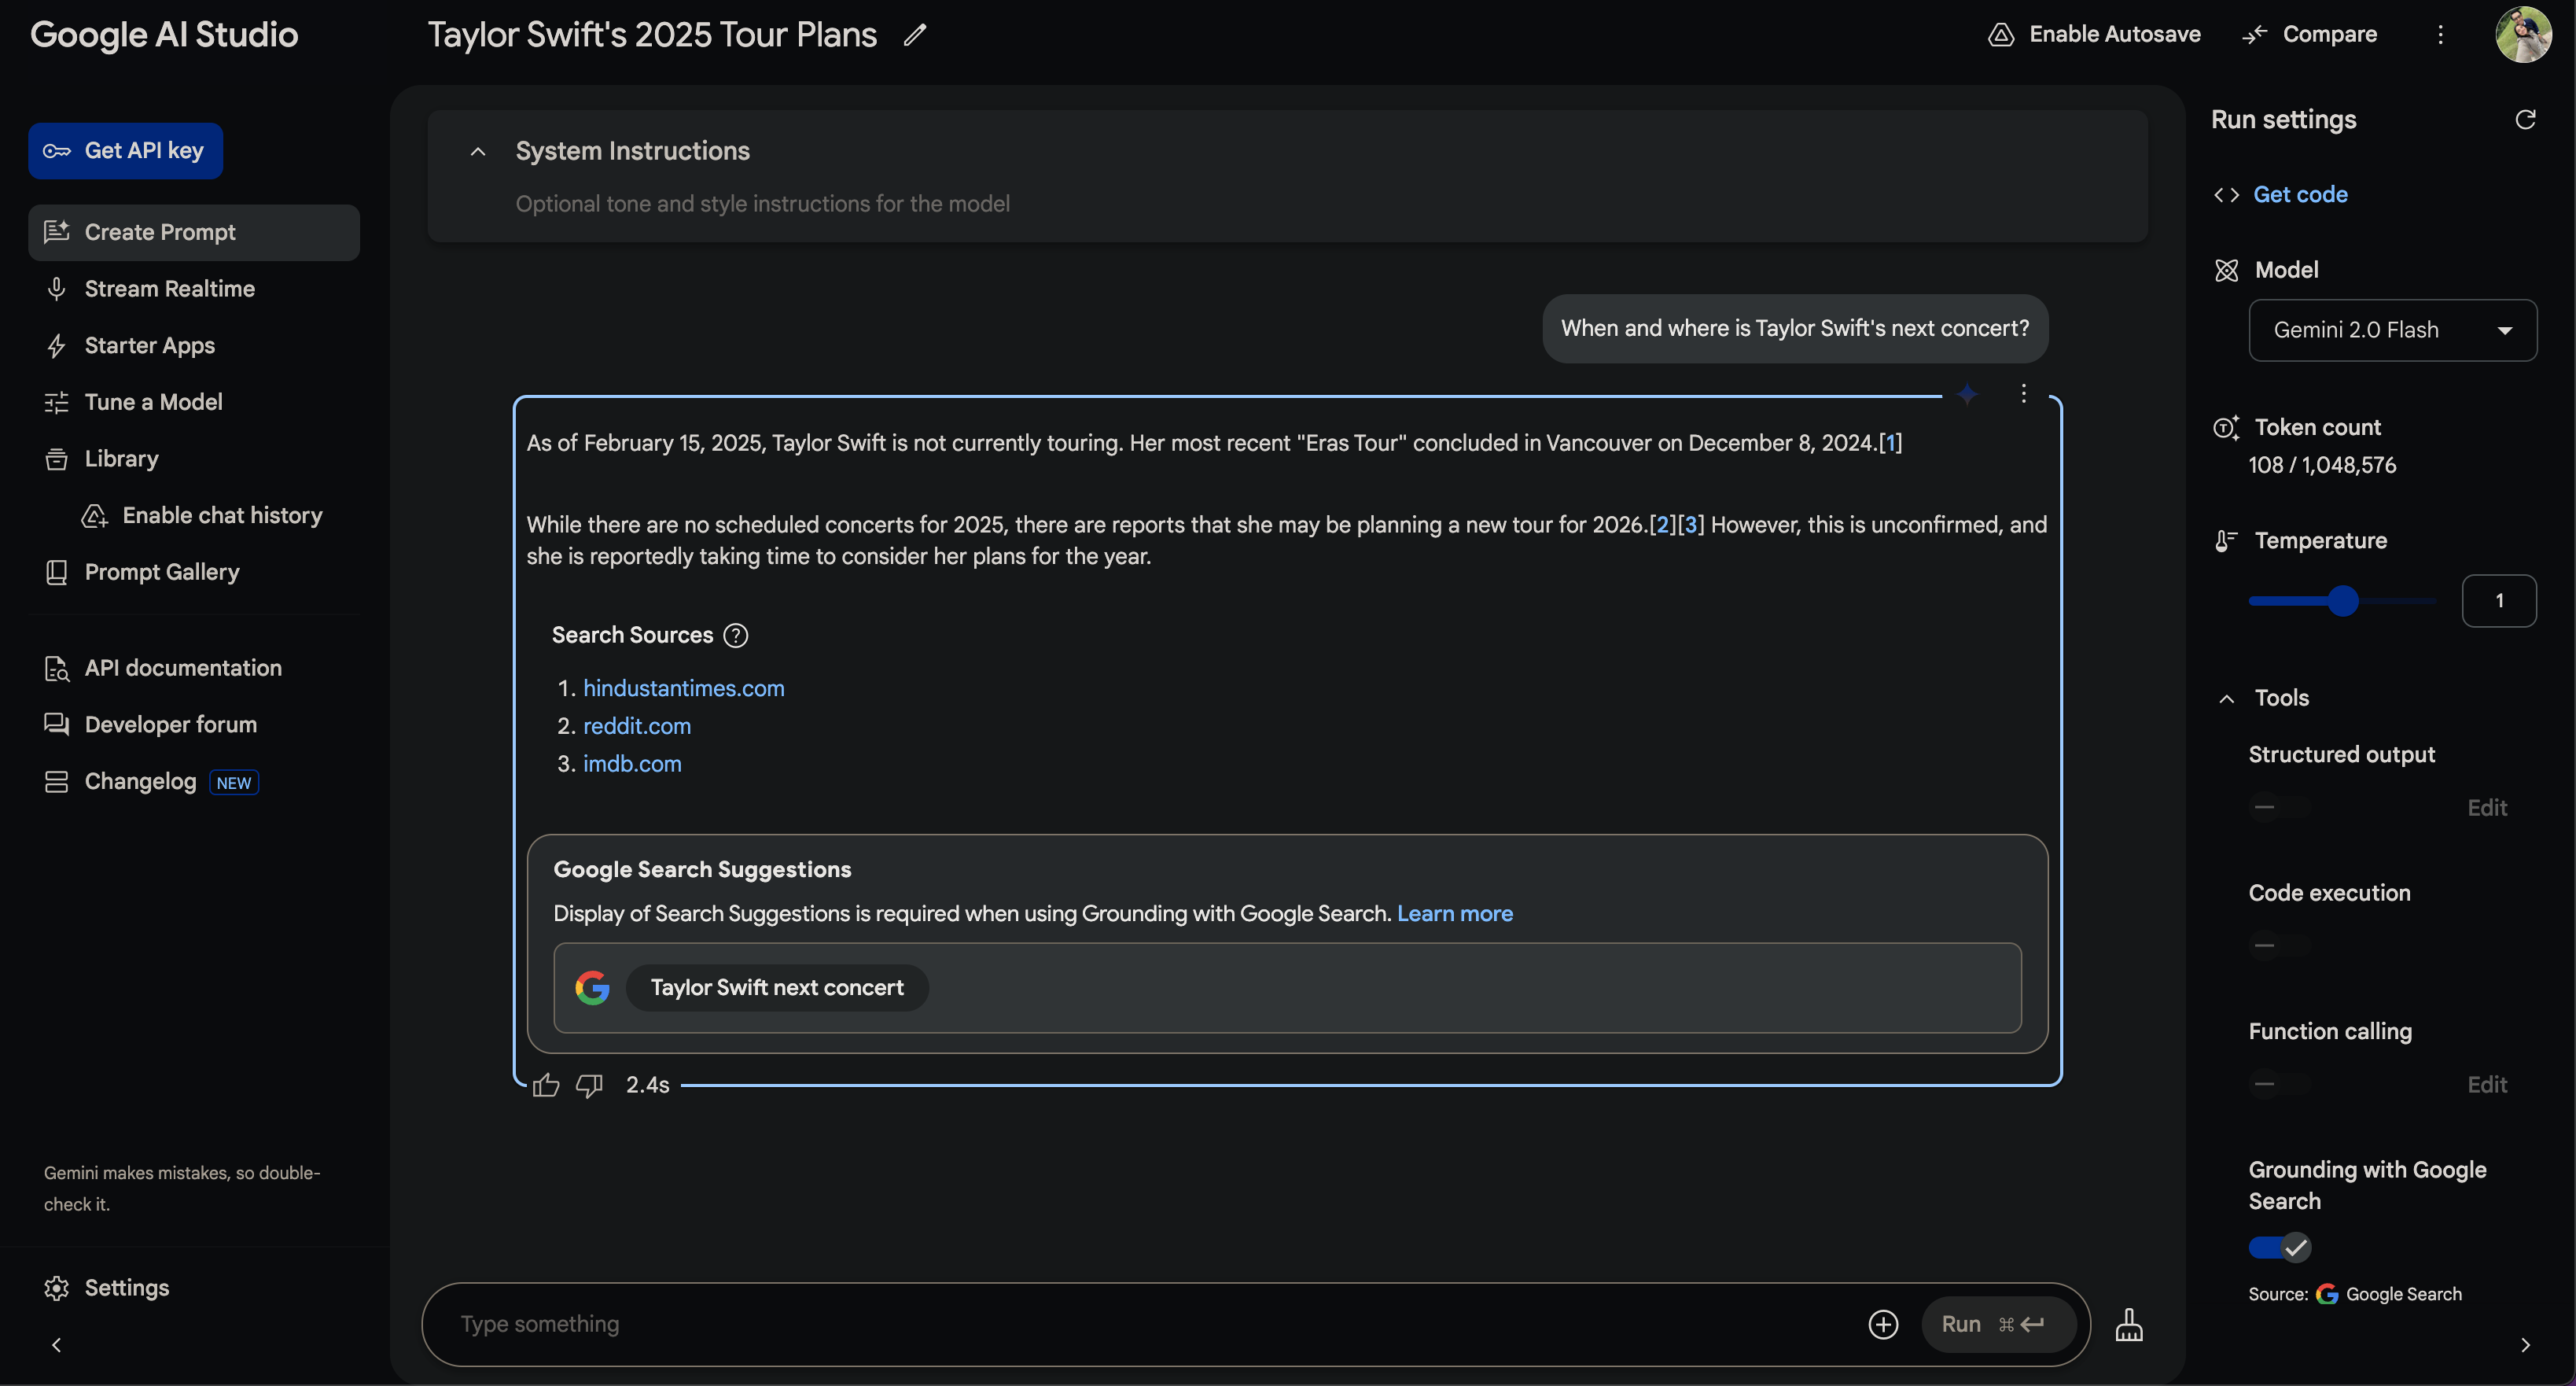

In [40]:
import io

markdown_buffer = io.StringIO()

# Print the text with footnote markers.
markdown_buffer.write("Supported text:\n\n")
for support in supports:
    markdown_buffer.write(" * ")
    markdown_buffer.write(
        response.text[support.segment.start_index : support.segment.end_index]
    )

    for i in support.grounding_chunk_indices:
        chunk = chunks[i].web
        markdown_buffer.write(f"<sup>[{i+1}]</sup>")

    markdown_buffer.write("\n\n")


# And print the footnotes.
markdown_buffer.write("Citations:\n\n")
for i, chunk in enumerate(chunks, start=1):
    markdown_buffer.write(f"* {i}: [{chunk.web.title}]({chunk.web.uri})\n")


Markdown(markdown_buffer.getvalue())

NameError: name 'supports' is not defined

In [41]:
nosearch_model = genai.GenerativeModel("gemini-1.5-flash-002")
chat = nosearch_model.start_chat()

# No search grounding.
r = chat.send_message("Hello friendly chatbot!")

# Enable search for just this turn.
r = chat.send_message(
    "Who took home the 2023 cricket world cup?", tools="google_search_retrieval"
)

Markdown(r.text)

ResourceExhausted: 429 Resource has been exhausted (e.g. check quota).

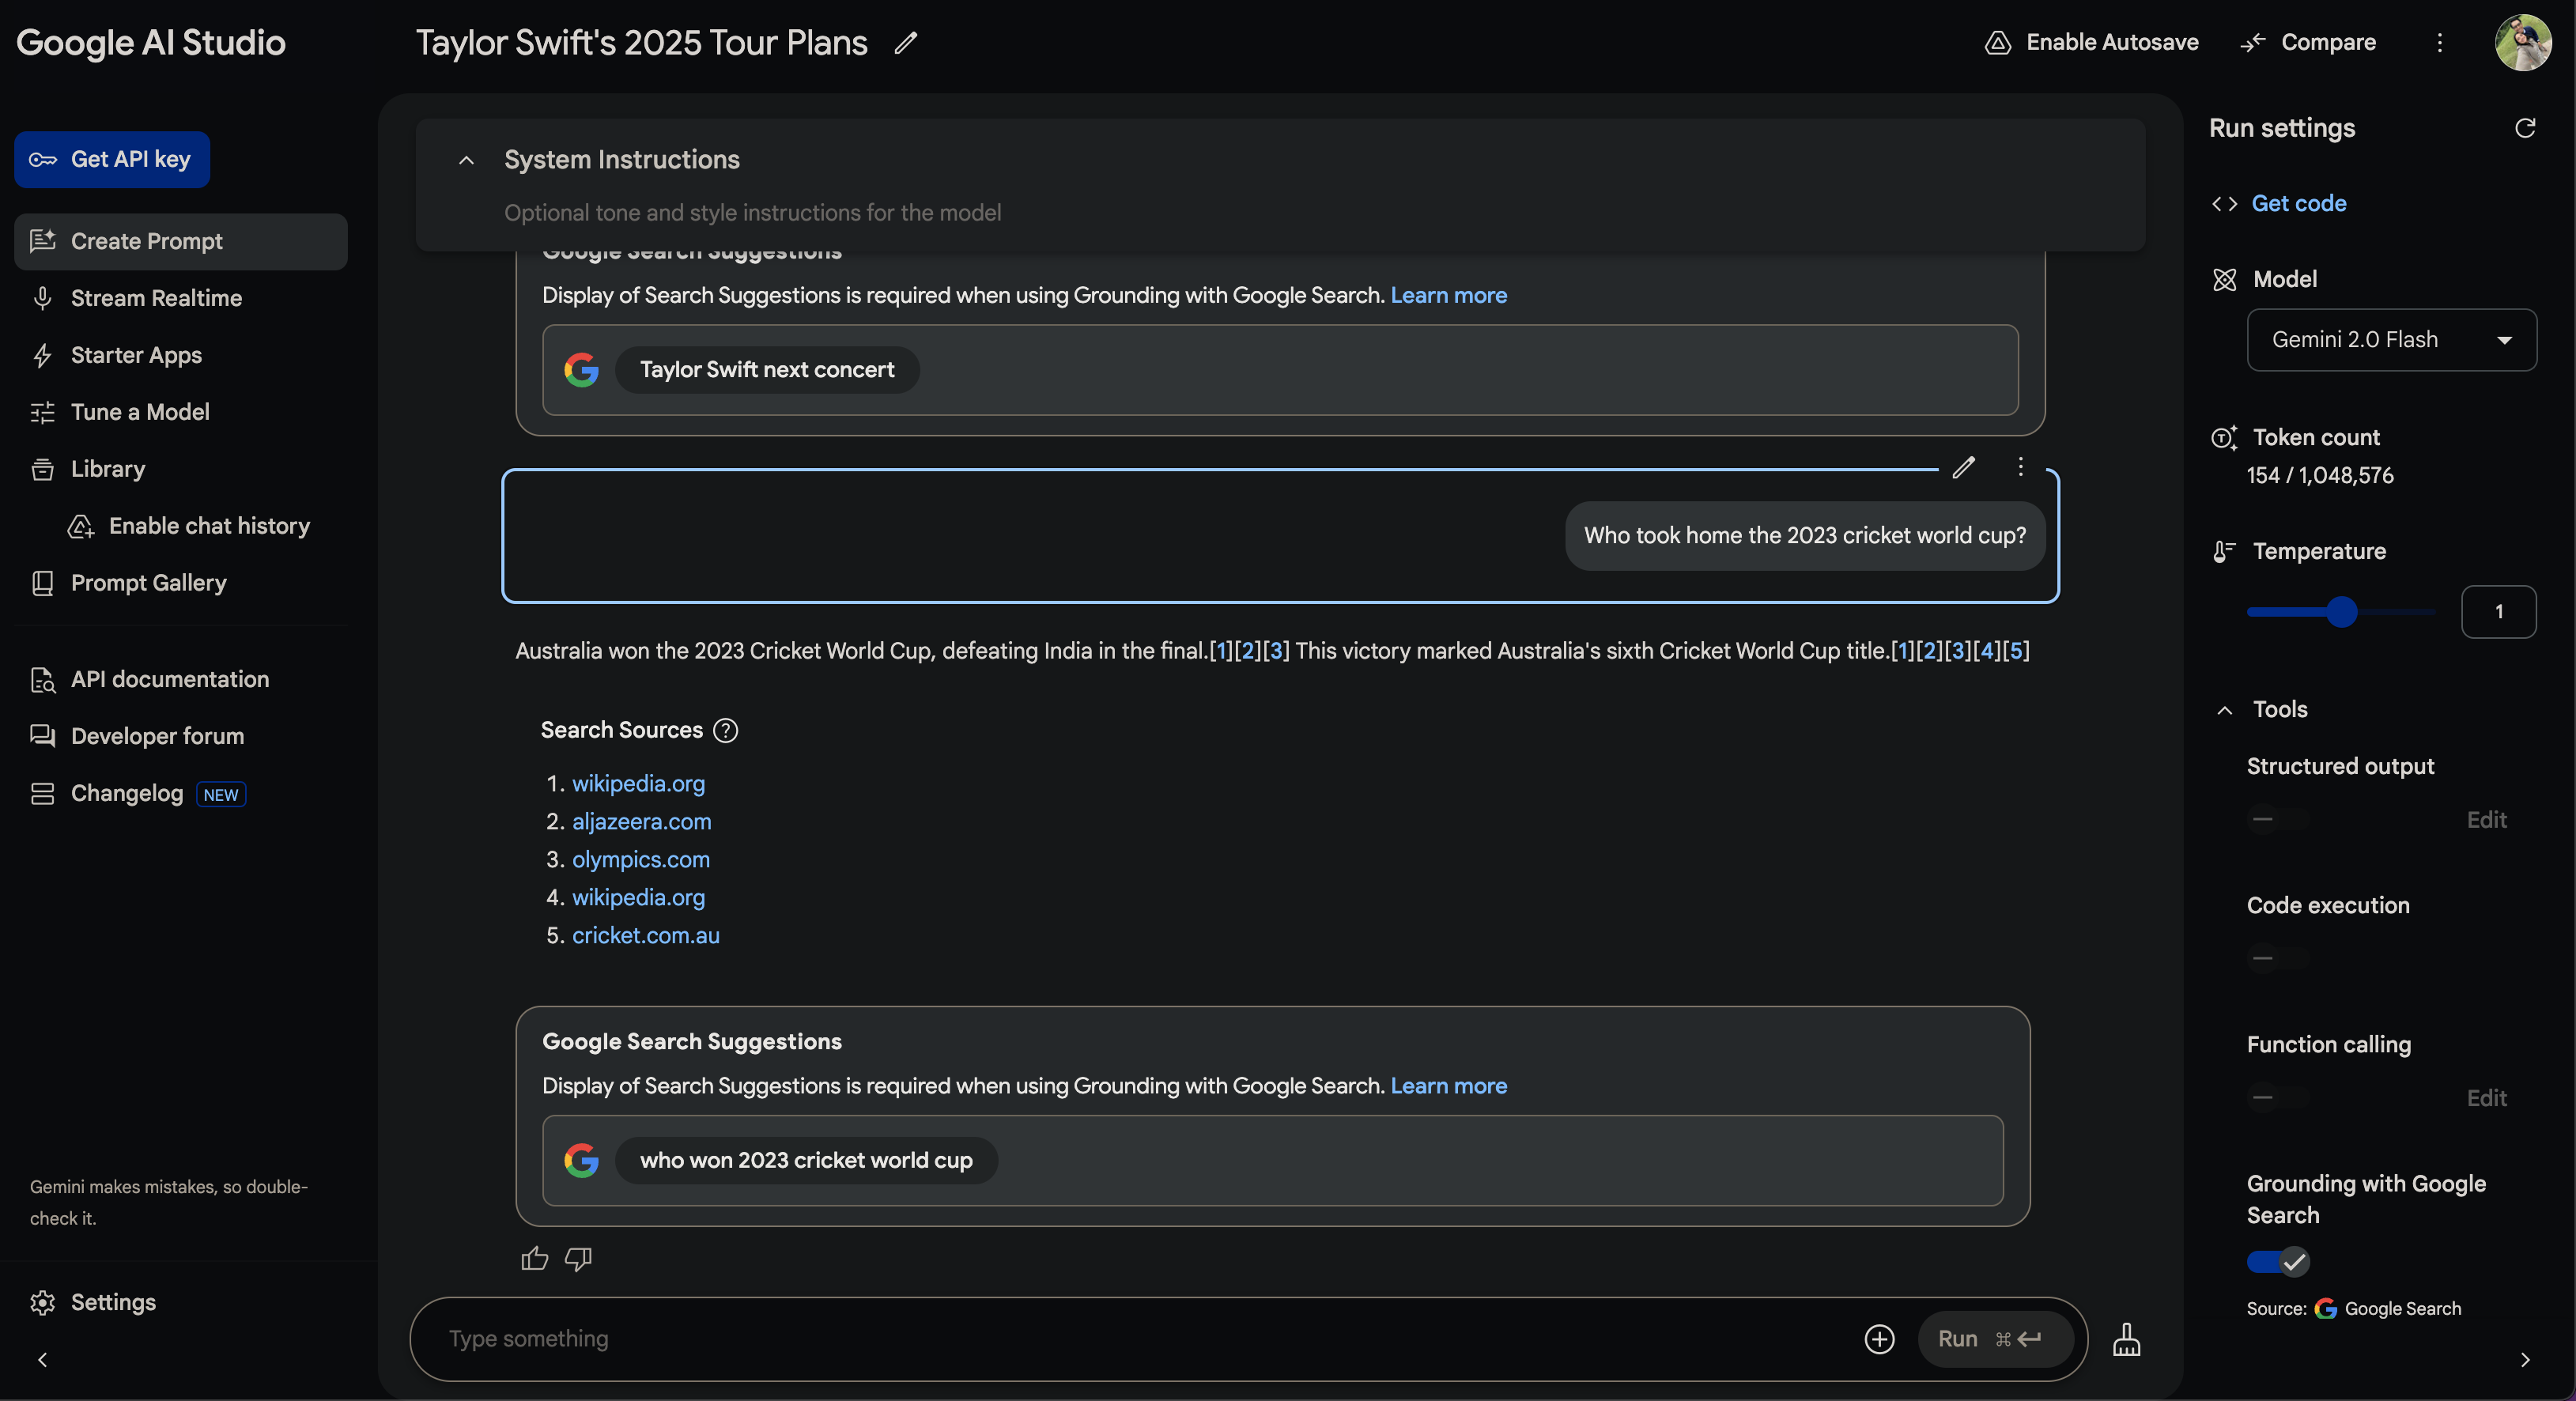

## Day 4 - Fine tuning a custom model

In [42]:
%pip install -U -q 'google-generativeai>=0.8.3'

Note: you may need to restart the kernel to use updated packages.


In [43]:
from kaggle_secrets import UserSecretsClient

#GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

In [44]:
for model in genai.list_models():
    if "createTunedModel" in model.supported_generation_methods:
        print(model.name)

models/gemini-1.0-pro-001
models/gemini-1.5-flash-001-tuning


In [45]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset="train")
newsgroups_test = fetch_20newsgroups(subset="test")

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [46]:
print(newsgroups_train.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [47]:
import email
import re

import pandas as pd


def preprocess_newsgroup_row(data):
    # Extract only the subject and body
    msg = email.message_from_string(data)
    text = f"{msg['Subject']}\n\n{msg.get_payload()}"
    # Strip any remaining email addresses
    text = re.sub(r"[\w\.-]+@[\w\.-]+", "", text)
    # Truncate the text to fit within the input limits
    text = text[:40000]

    return text


def preprocess_newsgroup_data(newsgroup_dataset):
    # Put data points into dataframe
    df = pd.DataFrame(
        {"Text": newsgroup_dataset.data, "Label": newsgroup_dataset.target}
    )
    # Clean up the text
    df["Text"] = df["Text"].apply(preprocess_newsgroup_row)
    # Match label to target name index
    df["Class Name"] = df["Label"].map(lambda l: newsgroup_dataset.target_names[l])

    return df

In [48]:
# Apply preprocessing to training and test datasets
df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head()

,Text,Label,Class Name
0,WHAT car is this!?\n\n I was wondering if anyo...,7,rec.autos
1,SI Clock Poll - Final Call\n\nA fair number of...,4,comp.sys.mac.hardware
2,"PB questions...\n\nwell folks, my mac plus fin...",4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\n\nRobert J.C. Kyanko () wr...,1,comp.graphics
4,Re: Shuttle Launch Question\n\nFrom article <>...,14,sci.space


In [49]:
def sample_data(df, num_samples, classes_to_keep):
    # Sample rows, selecting num_samples of each Label.
    df = (
        df.groupby("Label")[df.columns]
        .apply(lambda x: x.sample(num_samples))
        .reset_index(drop=True)
    )

    df = df[df["Class Name"].str.contains(classes_to_keep)]
    df["Class Name"] = df["Class Name"].astype("category")

    return df


TRAIN_NUM_SAMPLES = 50
TEST_NUM_SAMPLES = 10
# Keep rec.* and sci.*
CLASSES_TO_KEEP = "^rec|^sci"

df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

In [50]:
sample_idx = 0
sample_row = preprocess_newsgroup_row(newsgroups_test.data[sample_idx])
sample_label = newsgroups_test.target_names[newsgroups_test.target[sample_idx]]

print(sample_row)
print('---')
print('Label:', sample_label)

Need info on 88-89 Bonneville


 I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.

			Neil Gandler

---
Label: rec.autos


In [51]:
baseline_model = genai.GenerativeModel("gemini-1.5-flash-001")
response = baseline_model.generate_content(sample_row)
print(response.text)

## 1988-1989 Pontiac Bonnevilles: A Breakdown

You're right, the 1988-1989 Bonnevilles had a variety of trim levels that can be confusing! Let's break them down:

**Base Model:** The standard Bonneville was a comfortable and spacious car, often chosen for its value and practicality.

**LE (Luxury Edition):** The LE offered upgraded interior features like plusher seats, better sound systems, and more luxurious trim.

**SE (Special Edition):** The SE focused on sporty styling, often featuring unique wheels, body kits, and sportier interior accents. 

**LSE (Luxury Special Edition):** This model combined the luxury of the LE with some of the sporty styling elements of the SE.

**SSE (Sport Special Edition):**  The SSE was the performance-oriented model. It came with a more powerful V8 engine (the 5.0L V8 with 170hp), a firmer suspension, and more aggressive styling cues.

**SSEi (Sport Special Edition with Injection):** The SSEi was a further step up from the SSE, featuring a fuel-injecte

In [52]:
# Ask the model directly in a zero-shot prompt.

prompt = "From what newsgroup does the following message originate?"
baseline_response = baseline_model.generate_content([prompt, sample_row])
print(baseline_response.text)

This message most likely originates from a **Buick-specific newsgroup**, such as:

* **alt.autos.buick** 
* **rec.autos.buick**

These newsgroups were popular forums for Buick enthusiasts to discuss topics like model variations, pricing, and buying advice. 

The message's focus on specific Bonneville trim levels (LE, SE, LSE, SSE, SSEi) and its inquiry about book value and demand strongly suggests a Buick-related newsgroup. 



In [53]:
from google.api_core import retry

# You can use a system instruction to do more direct prompting, and get a
# more succinct answer.

system_instruct = """
You are a classification service. You will be passed input that represents
a newsgroup post and you must respond with the newsgroup from which the post
originates.
"""

instructed_model = genai.GenerativeModel("gemini-1.5-flash-001",
                                         system_instruction=system_instruct)

retry_policy = {"retry": retry.Retry(predicate=retry.if_transient_error)}

# If you want to evaluate your own technique, replace this function with your
# model, prompt and other code and return the predicted answer.
def predict_label(post: str) -> str:
    response = instructed_model.generate_content(post, request_options=retry_policy)
    rc = response.candidates[0]

    # Any errors, filters, recitation, etc we can mark as a general error
    if rc.finish_reason.name != "STOP":
        return "(error)"
    else:
        # Clean up the response.
        return response.text.strip()


prediction = predict_label(sample_row)

print(prediction)
print()
print("Correct!" if prediction == sample_label else "Incorrect.")

rec.autos.misc

Incorrect.


In [54]:
from tqdm.rich import tqdm

tqdm.pandas()


# Further sample the test data to be mindful of the free-tier quota.
df_baseline_eval = sample_data(df_test, 2, '.*')

# Make predictions using the sampled data.
df_baseline_eval['Prediction'] = df_baseline_eval['Text'].progress_apply(predict_label)

# And calculate the accuracy.
accuracy = (df_baseline_eval["Class Name"] == df_baseline_eval["Prediction"]).sum() / len(df_baseline_eval)
print(f"Accuracy: {accuracy:.2%}")

Output()

/usr/local/lib/python3.10/dist-packages/tqdm/std.py:885: TqdmExperimentalWarning: rich is experimental/alpha
  t = cls(total=total, **tqdm_kwargs)


Accuracy: 6.25%


In [55]:
df_baseline_eval

,Text,Label,Class Name,Prediction
0,Re: Lexus and Infiniti\n\nIn article <> (Issa...,7,rec.autos,rec.autos.misc
1,Question about Integra Auto box\n\n\nI'm new t...,7,rec.autos,rec.autos.honda
2,Re: I NEED YOUR ADVICE! (I'm a new rider)\n\nI...,8,rec.motorcycles,rec.motorcycles
3,Re: Please tell me they're not permenant scrat...,8,rec.motorcycles,rec.autos.misc
4,Re: How to speed up games (marginally realisti...,9,rec.sport.baseball,rec.games.baseball
5,Re: Game Length (was Re: Braves Update!!\n\nIn...,9,rec.sport.baseball,rec.sports.baseball
6,Re: Pens fans reactions\n\nRichard J Coyle (go...,10,rec.sport.hockey,rec.sports.hockey
7,Re: POTVIN & HIS STICK\n\nNothing wrong with w...,10,rec.sport.hockey,rec.sports.hockey
8,"Re: Overreacting (was Re: Once tapped, your co...",11,sci.crypt,talk.politics.misc
9,forbidden to reveal wiretap?\n\n\n If it's f...,11,sci.crypt,misc.legal


In [56]:
from collections.abc import Iterable
import random


# Append a random number to the model ID so you can re-run with a higher chance
# of creating a unique model ID.
model_id = f"newsgroup-classifier-{random.randint(10000, 99999)}"

# Upload the training data and queue the tuning job.
tuning_op = genai.create_tuned_model(
    "models/gemini-1.5-flash-001-tuning",
    training_data=df_train,
    input_key="Text",  # the column to use as input
    output_key="Class Name",  # the column to use as output
    id=model_id,
    display_name="Newsgroup classification model",
    batch_size=16,
    epoch_count=2,
)

print(model_id)

PermissionDenied: 403 You do not have permission to access tuned model newsgroup-classifier-70107.

In [57]:
import time
import seaborn as sns


while (tuned_model := genai.get_tuned_model(f"tunedModels/{model_id}")).state.name != 'ACTIVE':

    print(tuned_model.state)
    time.sleep(60)

print(f"Done! The model is {tuned_model.state.name}")

# Plot the loss curve.
snapshots = pd.DataFrame(tuned_model.tuning_task.snapshots)
sns.lineplot(data=snapshots, x="step", y="mean_loss")

InvalidArgument: 400 Request contains an invalid argument.

In [58]:
your_model = genai.GenerativeModel(f"tunedModels/{model_id}")

new_text = """
First-timer looking to get out of here.

Hi, I'm writing about my interest in travelling to the outer limits!

What kind of craft can I buy? What is easiest to access from this 3rd rock?

Let me know how to do that please.
"""

response = your_model.generate_content(new_text)
print(response.text)

InvalidArgument: 400 Request contains an invalid argument.

In [59]:
def classify_text(text: str) -> str:
    """Classify the provided text into a known newsgroup."""
    response = your_model.generate_content(text, request_options=retry_policy)
    rc = response.candidates[0]

    # Any errors, filters, recitation, etc we can mark as a general error
    if rc.finish_reason.name != "STOP":
        return "(error)"
    else:
        return rc.content.parts[0].text


# The sampling here is just to minimise your quota usage. If you can, you should
# evaluate the whole test set with `df_model_eval = df_test.copy()`.
df_model_eval = sample_data(df_test, 4, '.*')


df_model_eval["Prediction"] = df_model_eval["Text"].progress_apply(classify_text)

accuracy = (df_model_eval["Class Name"] == df_model_eval["Prediction"]).sum() / len(df_model_eval)
print(f"Accuracy: {accuracy:.2%}")

Output()

/usr/local/lib/python3.10/dist-packages/tqdm/std.py:885: TqdmExperimentalWarning: rich is experimental/alpha
  t = cls(total=total, **tqdm_kwargs)


InvalidArgument: 400 Request contains an invalid argument.

In [60]:
# Calculate the *input* cost of the baseline model with system instructions.
sysint_tokens = instructed_model.count_tokens(sample_row).total_tokens
print(f'System instructed baseline model: {sysint_tokens} (input)')

# Calculate the input cost of the tuned model.
tuned_tokens = your_model.count_tokens(sample_row).total_tokens
print(f'Tuned model: {tuned_tokens} (input)')

savings = (sysint_tokens - tuned_tokens) / tuned_tokens
print(f'Token savings: {savings:.2%}')  # Note that this is only n=1.

System instructed baseline model: 171 (input)


InvalidArgument: 400 Request contains an invalid argument.

In [61]:
baseline_token_output = baseline_response.usage_metadata.candidates_token_count
print('Baseline (verbose) output tokens:', baseline_token_output)

tuned_model_output = your_model.generate_content(sample_row)
tuned_tokens_output = tuned_model_output.usage_metadata.candidates_token_count
print('Tuned output tokens:', tuned_tokens_output)


Baseline (verbose) output tokens: 104


InvalidArgument: 400 Request contains an invalid argument.